 # Анализ результатов А/В теста

**Цель проекта:**
Провести оценку результатов A/B-теста, используя датасет с действиями пользователей, техническое задание и несколько вспомогательных датасетов.

**Ход исследования:**
1) Предобработка данных:
    - знакомство с данными
    - обработка пропусков и дубликатов
    - проверка соответствия требованиям технического задания
2) Исследовательский анализ:
    - анализ распределения числа событий на пользователя
    - анализ распределения числа событий в выборках по дням
    - изучение воронки событий
3) Анализ результатов А/В тестирования
4) Общий вывод по итогам проведения А/В теста

**Техническое задание**

- Название теста: `recommender_system_test`;
- группы: А — контрольная, B — новая платёжная воронка;
- дата запуска: 2020-12-07;
- дата остановки набора новых пользователей: 2020-12-21;
- дата остановки: 2021-01-04;
- аудитория: в тест должно быть отобрано 15% новых пользователей из региона EU;
- назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы;
- ожидаемое количество участников теста: 6000.
- ожидаемый эффект: за 14 дней с момента регистрации пользователи покажут улучшение каждой метрики не менее, чем на 10%:
    - конверсии в просмотр карточек товаров — событие `product_page`,
    - просмотры корзины — `product_cart`,
    - покупки — `purchase`.
    
**Описание данных**

`ab_project_marketing_events.csv` — календарь маркетинговых событий на 2020 год.

Структура файла:

- `name` — название маркетингового события;
- `regions` — регионы, в которых будет проводиться рекламная кампания;
- `start_dt` — дата начала кампании;
- `finish_dt` — дата завершения кампании.

`final_ab_new_users.csv` — пользователи, зарегистрировавшиеся с 7 до 21 декабря 2020 года.

Структура файла:

- `user_id` — идентификатор пользователя;
- `first_date` — дата регистрации;
- `region` — регион пользователя;
- `device` — устройство, с которого происходила регистрация.

`final_ab_events.csv` — действия новых пользователей в период с 7 декабря 2020 по 4 января 2021 года.

Структура файла:

- `user_id` — идентификатор пользователя;
- `event_dt` — дата и время события;
- `event_name` — тип события;
- `details` — дополнительные данные о событии. Например, для покупок, `purchase,` в этом поле хранится стоимость покупки в долларах.

`final_ab_participants.csv` — таблица участников тестов.

Структура файла:

- `user_id` — идентификатор пользователя;
- `ab_test` — название теста;
- `group` — группа пользователя.

## Предобработка данных

### Знакомство с данными

In [1]:
#загрузим необходимые библиотеки
import pandas as pd
import numpy as np
import seaborn as sns
import math as mth
import matplotlib.pyplot as plt
from scipy import stats as st
import plotly.express as px
import warnings
warnings.filterwarnings('ignore')

In [2]:
import plotly.io as pio 
pio.renderers.default = "png" 
svg_renderer = pio.renderers["png"] 
svg_renderer.scale = 1.2

In [3]:
# открываем файлы 
events = pd.read_csv('https://code.s3.yandex.net/datasets/final_ab_events.csv')
marketing_events = pd.read_csv('https://code.s3.yandex.net/datasets/ab_project_marketing_events.csv')
new_users = pd.read_csv('https://code.s3.yandex.net/datasets/final_ab_new_users.csv')
participants = pd.read_csv('https://code.s3.yandex.net/datasets/final_ab_participants.csv')

In [4]:
def preprocessing(df):
    '''
    функция для начальных этапов предобработки, проверки на пропуски и дубликаты
    '''
    df.info()
    display(df.describe())
    print('Пропущенных значений: \n{}\n'
         'Явных дубликатов: {}'.format(df.isna().sum(),
                                      df.duplicated().sum())
         )
    display(df.head(10))

In [5]:
preprocessing(events)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     440317 non-null  object 
 1   event_dt    440317 non-null  object 
 2   event_name  440317 non-null  object 
 3   details     62740 non-null   float64
dtypes: float64(1), object(3)
memory usage: 13.4+ MB


,details
count,62740.000000
mean,23.877631
std,72.180465
min,4.990000
25%,4.990000
50%,4.990000
75%,9.990000
max,499.990000


Пропущенных значений: 
user_id            0
event_dt           0
event_name         0
details       377577
dtype: int64
Явных дубликатов: 0


,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99
5,831887FE7F2D6CBA,2020-12-07 06:50:29,purchase,4.99
6,6B2F726BFD5F8220,2020-12-07 11:27:42,purchase,4.99
7,BEB37715AACF53B0,2020-12-07 04:26:15,purchase,4.99
8,B5FA27F582227197,2020-12-07 01:46:37,purchase,4.99
9,A92195E3CFB83DBD,2020-12-07 00:32:07,purchase,4.99


In [6]:
events['event_name'].unique()
#выведем уникальные значения категориального столбца, чтобы избежать неявных дубликатов

array(['purchase', 'product_cart', 'product_page', 'login'], dtype=object)

In [7]:
# превратим столбец с датой и временем просто в дату, так как время не пригодится для исследования
events['event_dt'] = pd.to_datetime(events['event_dt']).dt.date
events['event_dt'] = pd.to_datetime(events['event_dt'])

Есть 377577 пропусков в столбце details. Это вспомогательные данные, в которых содердится дополнительная информация к событиям (например, к событию purchase это сумма покупки в долларах), следовательно, наличие или отсутствие информации в этом столбце не повлияет на интерпретацию результатов А/В теста. Пропуски можно оставить без изменений. 

In [8]:
preprocessing(marketing_events)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 576.0+ bytes


,name,regions,start_dt,finish_dt
count,14,14,14,14
unique,14,6,14,14
top,Labor day (May 1st) Ads Campaign,APAC,2020-03-17,2020-07-01
freq,1,4,1,1


Пропущенных значений: 
name         0
regions      0
start_dt     0
finish_dt    0
dtype: int64
Явных дубликатов: 0


,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11
5,Black Friday Ads Campaign,"EU, CIS, APAC, N.America",2020-11-26,2020-12-01
6,Chinese New Year Promo,APAC,2020-01-25,2020-02-07
7,Labor day (May 1st) Ads Campaign,"EU, CIS, APAC",2020-05-01,2020-05-03
8,International Women's Day Promo,"EU, CIS, APAC",2020-03-08,2020-03-10
9,Victory Day CIS (May 9th) Event,CIS,2020-05-09,2020-05-11


In [9]:
# приведем даты к нужному формату
marketing_events['start_dt'] = pd.to_datetime(marketing_events['start_dt'])
marketing_events['finish_dt'] = pd.to_datetime(marketing_events['finish_dt'])

In [10]:
preprocessing(new_users)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     61733 non-null  object
 1   first_date  61733 non-null  object
 2   region      61733 non-null  object
 3   device      61733 non-null  object
dtypes: object(4)
memory usage: 1.9+ MB


,user_id,first_date,region,device
count,61733,61733,61733,61733
unique,61733,17,4,4
top,481A0E44E12AF38C,2020-12-21,EU,Android
freq,1,6290,46270,27520


Пропущенных значений: 
user_id       0
first_date    0
region        0
device        0
dtype: int64
Явных дубликатов: 0


,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone
5,137119F5A9E69421,2020-12-07,N.America,iPhone
6,62F0C741CC42D0CC,2020-12-07,APAC,iPhone
7,8942E64218C9A1ED,2020-12-07,EU,PC
8,499AFACF904BBAE3,2020-12-07,N.America,iPhone
9,FFCEA1179C253104,2020-12-07,EU,Android


In [11]:
# выведем уникальные значения категориальной переменной, чтобы исключить неявные дубликаты
new_users['region'].unique()

array(['EU', 'N.America', 'APAC', 'CIS'], dtype=object)

In [12]:
new_users['device'].unique()

array(['PC', 'Android', 'iPhone', 'Mac'], dtype=object)

In [13]:
new_users['first_date'] = pd.to_datetime(new_users['first_date'])

In [14]:
preprocessing(participants)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  18268 non-null  object
 1   group    18268 non-null  object
 2   ab_test  18268 non-null  object
dtypes: object(3)
memory usage: 428.3+ KB


,user_id,group,ab_test
count,18268,18268,18268
unique,16666,2,2
top,5191CB5D9AEFBC6F,A,interface_eu_test
freq,2,9655,11567


Пропущенных значений: 
user_id    0
group      0
ab_test    0
dtype: int64
Явных дубликатов: 0


,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test
5,4FF2998A348C484F,A,recommender_system_test
6,7473E0943673C09E,A,recommender_system_test
7,C46FE336D240A054,A,recommender_system_test
8,92CB588012C10D3D,A,recommender_system_test
9,057AB296296C7FC0,B,recommender_system_test


In [15]:
# выведем уникальные значения категориальной переменной, чтобы исключить неявные дубликаты
participants['ab_test'].unique()

array(['recommender_system_test', 'interface_eu_test'], dtype=object)

Данные при первом знакомстве считываются корректно, дубликатов не выявлено, пропуски обнаружены только в деталях событий, не повлияют на ход исследования. Скорректированы типы данных.

### Проверка соответствия данных требованиям технического задания


1) Название теста - recommender_system_test, группы: А — контрольная, B — новая платёжная воронка, назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы

In [16]:
participants.groupby(['ab_test', 'group']).agg({'user_id':'count'})

user_id
ab_test                 group         
interface_eu_test       A         5831
                        B         5736
recommender_system_test A         3824
                        B         2877

In [17]:
participants_recommender = participants.query('ab_test == "recommender_system_test"')

Как видно на сводной таблице, вместе с нашим А/В тестом изменений, связанных с внедрением улучшенной рекомендательной системы проводили еще один, более масштабный - "interface_eu_test". Необходимо уделить внимание при подготовке результатов на то, чтобы пересечение пользователей в этих двух тестах не повлияло на результат эксперимента.

2) Корректность времени проведения теста:
- дата запуска: 2020-12-07;
- дата остановки набора новых пользователей: 2020-12-21;
- дата остановки: 2021-01-04;

In [18]:
users_ab = participants_recommender.merge(new_users, on='user_id', how='left')

In [19]:
print('Дата запуска теста: {}\n'
      'Дата остановки набора новых пользователей: {}\n'
      'Последние события в датасете: {}'.format(users_ab['first_date'].min(),
                                                users_ab['first_date'].max(),
                                               events['event_dt'].max())
     )

Дата запуска теста: 2020-12-07 00:00:00
Дата остановки набора новых пользователей: 2020-12-21 00:00:00
Последние события в датасете: 2020-12-30 00:00:00


Даты запуска теста и остановки набора новых пользователей соответствуют тз. Остановка теста произведена раньше обоначенного срока на 5 дней, это может сильно повлиять на интерпретацию результатов эксперимента, поскольку не достигнут размер выборки, который сделает результаты статистически значимыми.

3) Аудитория: в тест должно быть отобрано 15% новых пользователей из региона EU; ожидаемое количество участников теста: 6000.

In [20]:
test_users_id = new_users.query('region == "EU" and first_date<= "2020-12-21"')['user_id']
m = participants_recommender.query('user_id in @test_users_id')['user_id']
print('Новых пользователей из EU: {}\n'
      'Всего пользователей из EU в тесте recommender_system_test: {}\n'
    'Доля новых пользователей из EU, отобранных в тест: {}%\n'
     'Количество участников теста: {}'.format(test_users_id.nunique(),
                                             m.nunique(),
                                             round(m.nunique()/test_users_id.nunique()*100,2),
                                             participants_recommender['user_id'].nunique()))

Новых пользователей из EU: 42340
Всего пользователей из EU в тесте recommender_system_test: 6351
Доля новых пользователей из EU, отобранных в тест: 15.0%
Количество участников теста: 6701


Предоставленные данные соответствуют ТЗ, 15% новых пользователей из Европы за выбранный период, всего участников теста 6701 человек.

### Проверка корректности времени проведения теста

Далее необходимо проверить, не совпадает ли время проведения эксперимента с маркетинговыми или другими активностями. Для этого исследуем таблицу marketing_events.

In [21]:
marketing_events[(marketing_events['start_dt'] >= '2020-12-07') & (marketing_events['start_dt'] <= '2020-12-30')]

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
10,CIS New Year Gift Lottery,CIS,2020-12-30,2021-01-07


Во время проведения теста в регионе EU проводилась промоакция "Cristmas@New Year Promo" - это является нарушением проведения теста, так как любые промоакции влияют на поведение клиента, соответственно, искажают результаты эксперимента.

### Проверка аудитории теста

Для начала проверим географическую принадлежность участников теста:

In [22]:
users_ab.groupby('region').agg({'user_id':'nunique'})

,user_id
region,
APAC,72
CIS,55
EU,6351
N.America,223


Для проведения теста по условиям нужны только пользователи из EU. Удалим лишних:

In [23]:
users_ab = users_ab.query('region == "EU"')

Далее проверим пересечения наших участников с конкурирующим тестом:

In [24]:
users_ab_id = users_ab['user_id']
double = (participants.query('user_id in @users_ab_id')
             .groupby('user_id').agg({'ab_test':'nunique'}).query('ab_test > 1').reset_index())
double_id = double['user_id']
print('Участников, попавших в оба теста:', double['ab_test'].count())

Участников, попавших в оба теста: 1602


Всего обнаружено 1602 участника, попавших в оба теста. Это является грубым нарушением проведения эксперимента, так как влияние, оказанное на участников может привести к искажению результатов тестов и снижению точности выводов. Однако, если участники попали в группу A конкурирующего теста, на них не было оказано влияние и их можно оставить, а попавших в группу В удалить.

In [25]:
print('Участников теста, попавших в группу А конкурирующего:', 
      participants.query('user_id in @double_id and ab_test == "interface_eu_test" and group == "B"')['user_id'].nunique())
print('Участников теста, попавших в группу В конкурирующего:',
     participants.query('user_id in @double_id and ab_test == "interface_eu_test" and group == "A"')['user_id'].nunique())

Участников теста, попавших в группу А конкурирующего: 783
Участников теста, попавших в группу В конкурирующего: 819


In [26]:
# удалим участников, попавших в группу В конкурирующего теста
id_to_delete = participants.query('user_id in @double_id and ab_test == "interface_eu_test" and group == "A"')['user_id']
users_ab = users_ab.query('user_id not in @id_to_delete')
print('Осталось после удаления пересечений с конкурирующим тестом:', users_ab['user_id'].count())


Осталось после удаления пересечений с конкурирующим тестом: 5532


Далее проверим равномерность распределения участников между группами теста и нет ли участников, попавших в обе группы.

In [27]:
print('Участников теста, попавших в обе группы:',
      users_ab.groupby('user_id').agg({'group':'count'}).query('group > 1')['group'].count())

Участников теста, попавших в обе группы: 0


In [28]:
group_counts = users_ab.groupby('group')['user_id'].count()
total_count = group_counts.sum()
group_proportions = group_counts.apply(lambda x: (x/total_count)*100)

# Combine the count and proportion columns into a single DataFrame
result_df = pd.concat([group_counts, group_proportions], axis=1)
result_df.columns = ['count', 'proportion']

# Display the result
print(result_df)



       count  proportion
group                   
A       3152   56.977585
B       2380   43.022415


Участников в группе А больше, чем в группе В, это является нарушением проведения А/В теста, так как сбор одинакового количества участников в группах A/B теста важен для обеспечения баланса между группами и уменьшения влияния внешних факторов на результаты теста. Результаты теста могут быть искажены, так как различия в поведении участников могут быть связаны не с изменением тестируемого элемента, а с другими факторами, такими как возраст, пол, географическое расположение и т.д.

Далее проверим данные на соответствие установленному в ТЗ лайфтайму пользователей - 14 дней.

In [29]:
full_table = users_ab.merge(events, on='user_id', how='left')
full_table

,user_id,group,ab_test,first_date,region,device,event_dt,event_name,details
0,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-07,purchase,99.99
1,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-25,purchase,4.99
2,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-07,product_cart,NaN
3,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-25,product_cart,NaN
4,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-07,product_page,NaN
...,...,...,...,...,...,...,...,...,...
22884,80712ED4EA1B52A5,A,recommender_system_test,2020-12-14,EU,Android,2020-12-15,product_page,NaN
22885,80712ED4EA1B52A5,A,recommender_system_test,2020-12-14,EU,Android,2020-12-20,product_page,NaN
22886,80712ED4EA1B52A5,A,recommender_system_test,2020-12-14,EU,Android,2020-12-14,login,NaN
22887,80712ED4EA1B52A5,A,recommender_system_test,2020-12-14,EU,Android,2020-12-15,login,NaN


In [30]:
# создададим столбец, в котором посчитаем разницу во времени между регистрацией и совершением события
full_table['lifetime'] = full_table['event_dt']-full_table['first_date']

In [31]:
# удалим события, не подходящие по требованиям к проведению эксперимента (более 14 дней с момента регистрации)
full_table = full_table.query('lifetime <= "14 days"')

Также нужно удалить пользователей, зарегистированных после 17 декабря, так как до конца эксперимента не прошло 14 дней с их регистрации. Это необходимо для того, чтобы избежать искажения в результатах исследования при расчете показателей конверсии.

In [32]:
# удалим пользователей, зарегистрированных после 17 декабря
full_table = full_table.query('first_date <="2020-12-17"')

### Повторная проверка соответствиям требований технического задания

После очистки данных от не подходящих для анализа результатов, проведем повторную проверку соответствия требованиям ТЗ:

In [33]:
print('Дата запуска теста: {}\n'
      'Дата остановки набора новых пользователей: {}\n'
      'Последние события в датасете: {}'.format(full_table['first_date'].min(),
                                                full_table['first_date'].max(),
                                               full_table['event_dt'].max())
     )

Дата запуска теста: 2020-12-07 00:00:00
Дата остановки набора новых пользователей: 2020-12-17 00:00:00
Последние события в датасете: 2020-12-29 00:00:00


In [34]:
test_users_id = new_users.query('region == "EU" and first_date<= "2020-12-21"')['user_id']
m = participants_recommender.query('user_id in @test_users_id')['user_id']
print('Новых пользователей из EU: {}\n'
      'Всего пользователей из EU в тесте recommender_system_test: {}\n'
    'Доля новых пользователей из EU, отобранных в тест: {}%\n'
     'Количество участников теста: {}'.format(test_users_id.nunique(),
                                             full_table['user_id'].nunique(),
                                             round(full_table['user_id'].nunique()/test_users_id.nunique()*100,2),
                                             full_table['user_id'].nunique()))

Новых пользователей из EU: 42340
Всего пользователей из EU в тесте recommender_system_test: 1866
Доля новых пользователей из EU, отобранных в тест: 4.41%
Количество участников теста: 1866


In [35]:
print('Количество участников теста по группам:')
quantity_users = full_table.groupby('group').agg({'user_id':'nunique'})
print(quantity_users)

Количество участников теста по группам:
       user_id
group         
A         1309
B          557


При подробном изучении предоставленных данных на предмет соответствия требованиям технического задания обнаружено большое количество нарушений:
1) Тест остановлен 30.12.2022, по ТЗ данные должны были собираться до 4.01.2023\
2) Во время проведения теста в регионе EU проводилась промоакция "Cristmas@New Year Promo" - это является нарушением проведения теста, так как любые промоакции влияют на поведение клиента, соответственно, искажают результаты эксперимента\
3) Обнаружено параллельное проведение другого А/В теста, в котором найдены пересекающиеся с нашим тестом участники (всего 1602). Это является грубым нарушением проведения эксперимента, так как влияние, оказанное на участников может привести к искажению результатов тестов и снижению точности выводов. 783 из них были в группе А конкурирующего теста, на них не было оказано влияние. 819 человек попали в группу В конкурирующего теста. Это повлияло на их результат, соответственно они были удалены.\
4) Участников в группе А больше, чем в группе В, это является нарушением проведения А/В теста, так как сбор одинакового количества участников в группах A/B теста важен для обеспечения баланса между группами и уменьшения влияния внешних факторов на результаты теста. Результаты теста могут быть искажены, так как различия в поведении участников могут быть связаны не с изменением тестируемого элемента\
5) Данные были отредактированы - очерчен лайфтайм пользователя - 14 дней, удалены превышающие этот период события и пользователи, "не дожившие" до окончания лайфтайма из-за преждевременной остановки эксперимента\
6) После очистки данных изменились показатели, которые были соблюдены в сырых - количество участников сократилось до 1866, что гораздо меньше заявленных 6000, доля новых пользователей из региона EU сократилась до 4.41%, что гораздо меньше требуемых 15%.

## Исследовательский анализ

### Распределение количества событий на пользователя

Выведем на экран гистограмму общего распределения событий на одного пользователя без учета деления на группы:

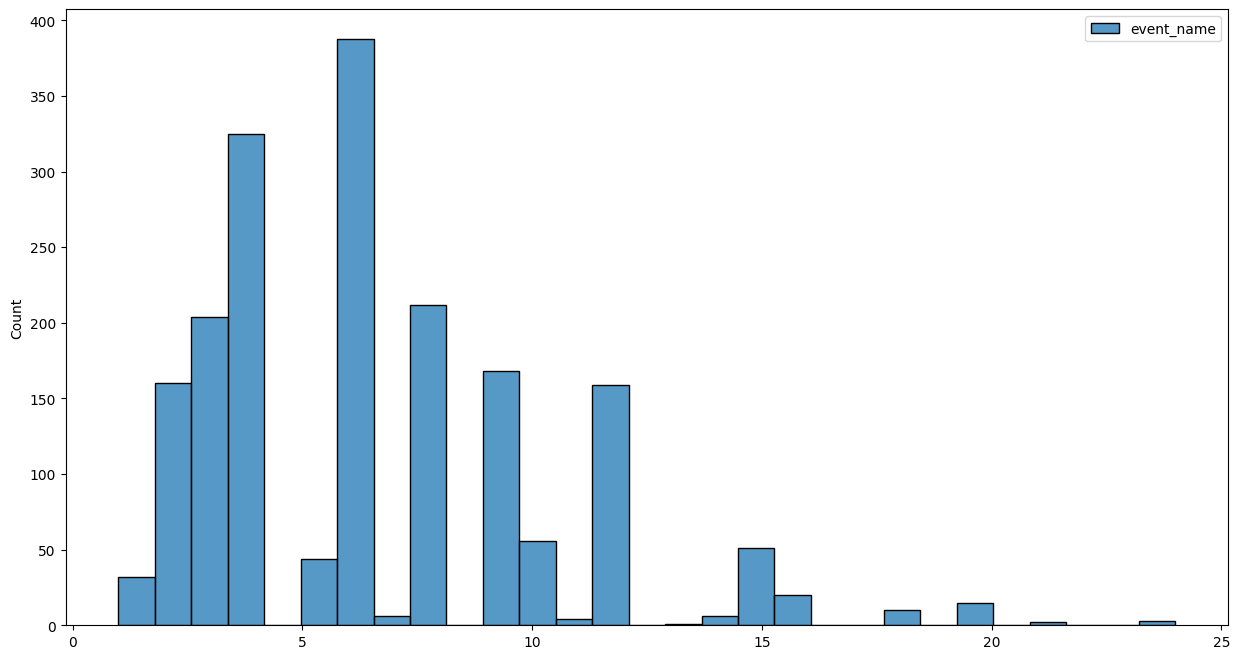

In [36]:
plt.figure(figsize=(15, 8))
sns.histplot(full_table.groupby(['group','user_id']).agg({'event_name':'count'}))
plt.show()

На гистограмме видно, что большая часть пользователей совершила от 3 до 7 событий. Количество событий на пользователя распределено неравномерно, отчетливо видны пики и провалы в значениях.

Далее рассмотрим количество пользователей, совершивших событие с разделением на группы. Для этого создадим сводную таблицу и выведем столбчатую диаграмму.

In [37]:
pivot_event = full_table.pivot_table(index=['group','event_name'], 
                aggfunc={'user_id':'nunique'}).reset_index()
for index, row in pivot_event.iterrows():
    if row['group'] == "A":
        pivot_event.loc[index, 'all_users_group'] = quantity_users['user_id']['A']
    elif row['group'] == "B":
        pivot_event.loc[index, 'all_users_group'] = quantity_users['user_id']['B']
pivot_event['percent_per_all_users_group'] = round(pivot_event['user_id']/pivot_event['all_users_group']*100,2)
pivot_event['event/user'] = round(pivot_event['all_users_group']/pivot_event['user_id']*100,2)
display(pivot_event)

,group,event_name,user_id,all_users_group,percent_per_all_users_group,event/user
0,A,login,1309,1309.0,100.00,100.00
1,A,product_cart,401,1309.0,30.63,326.43
2,A,product_page,842,1309.0,64.32,155.46
3,A,purchase,390,1309.0,29.79,335.64
4,B,login,556,557.0,99.82,100.18
5,B,product_cart,162,557.0,29.08,343.83
6,B,product_page,319,557.0,57.27,174.61
7,B,purchase,158,557.0,28.37,352.53


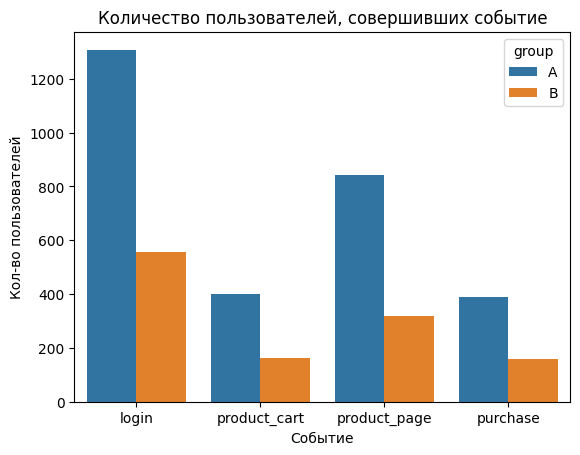

In [38]:
sns.barplot(data=pivot_event, x='event_name', y='user_id', hue = 'group')
plt.title('Количество пользователей, совершивших событие')
plt.ylabel('Кол-во пользователей')
plt.xlabel('Событие')
plt.show()

Всего пользователи совершают 4 события: вход, переход на страницу продукта, переход на страницу корзины и покупка товара.
Чаще всего происходит событие - login, реже всего пользователи обеих групп совершают покупку. Один пользователь из группы В миновал событие login. На графике видно, что количество пользователей, совершающих события в группе А сильно больше. Это связано, в первую очередь, с тем, что при проведении теста допущено неравномерное распределение прользователей между группами, что усложняет интерпретацию результатов.

Также рассмотрим среднее количество событий на одного пользователя по группам:

In [39]:
events_per_user = full_table.groupby(['group', 'user_id']).agg({'event_name':'count'})
avg_events = events_per_user.groupby('group').mean().round(2)
print('Среднее количество событий на пользователя по группам:', avg_events)


Среднее количество событий на пользователя по группам:        event_name
group            
A            6.96
B            5.83


Проведем статистическую проверку равенства средних с помощью t-теста.\
Сформулируем гипотезы\
H_0: Среднее количество событий на пользователя в группе А = Среднее количество событий на пользователя в группе В
H_1: Среднее количество событий на пользователя в группе А ≠ Среднее количество событий на пользователя в группе В
alpha = 0.05

In [40]:
events_per_user_a = events_per_user.query('group == "A"')
events_per_user_b = events_per_user.query('group == "B"')
results = st.ttest_ind(events_per_user_a, events_per_user_b, equal_var=True)#ttest, признаем дисперсии равными


alpha = .05
#значение уровня значимости

print(results.pvalue)# вывод значения p-value на экран 
if (results.pvalue < alpha):
    print('Отвергаем нулевую гипотезу: есть значимая разница')
else:
    print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными')

# условный оператор с выводом строки с ответом

[4.51092263e-09]
Отвергаем нулевую гипотезу: есть значимая разница


Среднее количество событий на пользователя в группе А - 6.96, в группе В - 5.83. Проведенный t-test подтвердил наличие статистически значимых различий между этими двумя средними.

### Распределение числа событий в выборках по дням

Далее изучим распределение числа событий в выборках по дням:

In [41]:
full_table['event_dt'] = full_table['event_dt'].dt.date
# сгруппирем данные по дням и типам событий
days = full_table.groupby(['event_dt', 'group']).agg({'event_name':'count'}).reset_index()

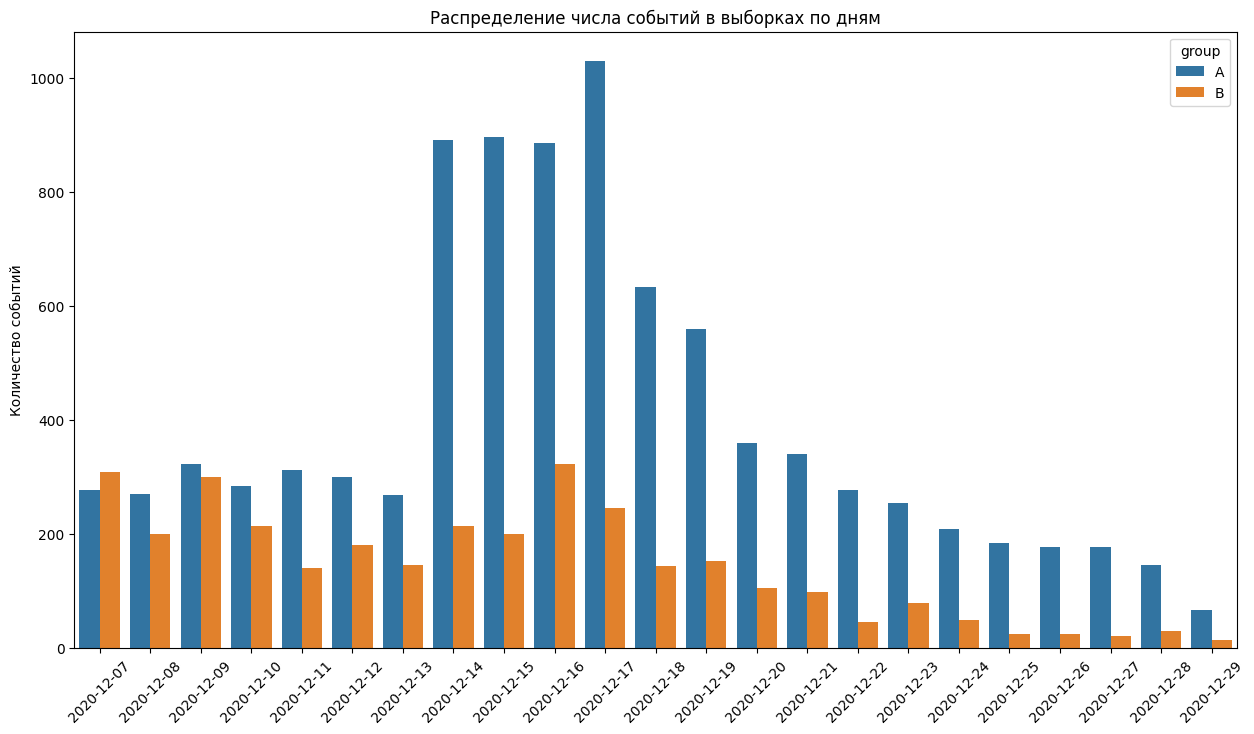

In [42]:
plt.figure(figsize=(15, 8))
sns.barplot(x='event_dt', y='event_name', hue = 'group', data = days)
plt.title('Распределение числа событий в выборках по дням')
plt.xlabel('')
plt.ylabel('Количество событий')
plt.xticks(rotation = 45)
plt.show()

События во время проведения эксперимента равномерно распределены по дням, однако, в группе А замете большой всплеск количества событий с 14 по 18 декабря. Для того, чтобы определить возможные причины этого скачка рассмотрим динамику набора пользователей.

In [43]:
full_table['first_date'] = full_table['first_date'].dt.date
users_collection = full_table.groupby(['first_date', 'group']).agg({'user_id':'count'}).reset_index()

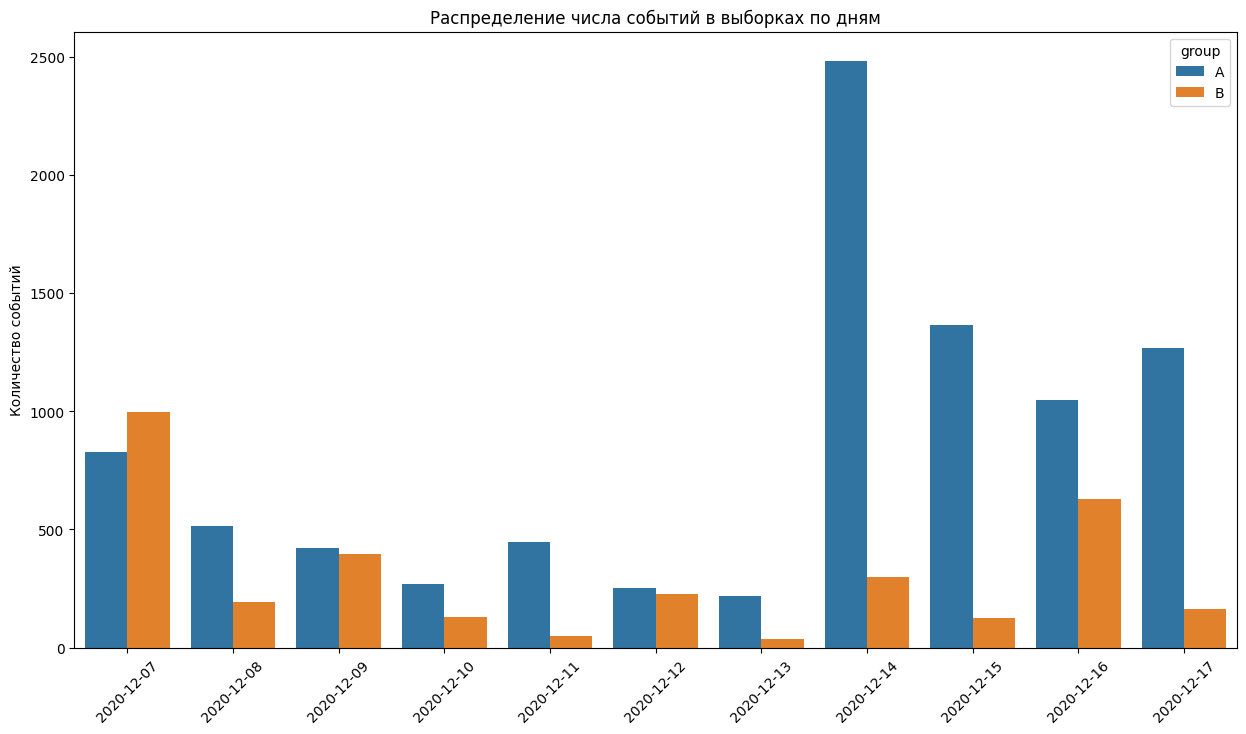

In [44]:
plt.figure(figsize=(15, 8))
sns.barplot(x='first_date', y='user_id', hue = 'group', data = users_collection)
plt.title('Распределение числа событий в выборках по дням')
plt.xlabel('')
plt.ylabel('Количество событий')
plt.xticks(rotation = 45)
plt.show()

На графике регистрации новых пользователей по дням заметно резкое увеличение количества регистраций 14 декабря, и боольшое количество с 15 по 17 декабря. Это объясняет большое количество пользовательских событий в эти и несколько последующих дней.

### Изучение воронки событий

Далее изучим воронку событий:

In [45]:
# создадим сводную таблицу для графического построения воронки
funnel = full_table.pivot_table(index=['group','event_name'], 
                aggfunc={'user_id':'nunique'}).reset_index()
event_dict = {
    'login':'1_login',
    'product_page': '2_product_page',
    'product_cart':'3_product_cart',
    'purchase':'4_purchase'
}
funnel['event_name'] = funnel['event_name'].map(dict(event_dict))
funnel = funnel.sort_values(by=['group', 'event_name'])

In [46]:
# также выведем на экран таблицы, отражающие воронки для групп эксперимента отдельно. 
# посчитаем процент для каждого шага по отношению к предыдущему и к общему количеству
a_funnel = funnel.query('group == "A"')
a_funnel['percent_per_previous'] = round(a_funnel['user_id']/a_funnel['user_id'].shift(1)*100,2)
a_funnel['percent_per_previous'] = a_funnel['percent_per_previous'].fillna(100.00)
a_funnel['percent_per_all_users'] = round(a_funnel['user_id']/a_funnel['user_id'].iloc[0]*100,2)
b_funnel = funnel.query('group == "B"')
b_funnel['percent_per_previous'] = round(b_funnel['user_id']/b_funnel['user_id'].shift(1)*100,2)
b_funnel['percent_per_previous'] = b_funnel['percent_per_previous'].fillna(100.00)
b_funnel['percent_per_all_users'] = round(b_funnel['user_id']/b_funnel['user_id'].iloc[0]*100,2)
display(a_funnel, b_funnel)

,group,event_name,user_id,percent_per_previous,percent_per_all_users
0,A,1_login,1309,100.00,100.00
2,A,2_product_page,842,64.32,64.32
1,A,3_product_cart,401,47.62,30.63
3,A,4_purchase,390,97.26,29.79


,group,event_name,user_id,percent_per_previous,percent_per_all_users
4,B,1_login,556,100.00,100.00
6,B,2_product_page,319,57.37,57.37
5,B,3_product_cart,162,50.78,29.14
7,B,4_purchase,158,97.53,28.42


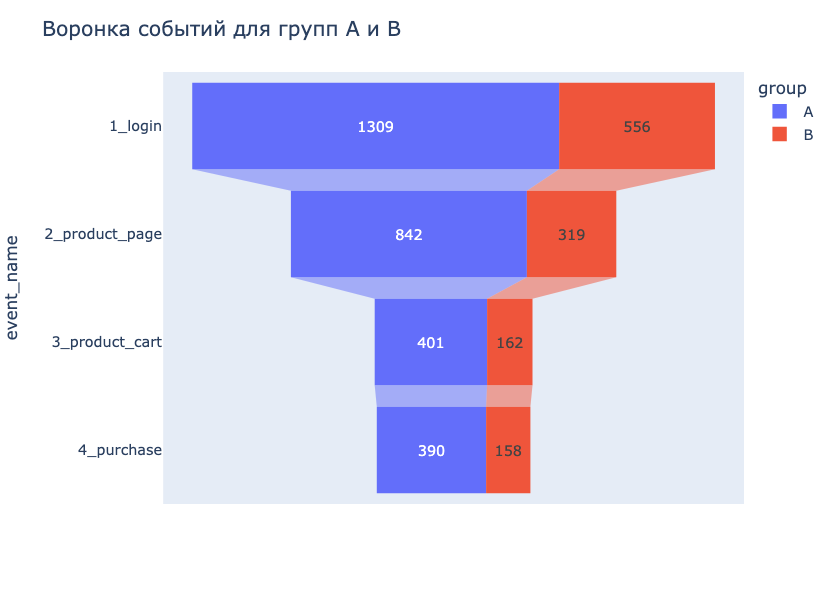

In [47]:
fig = px.funnel(funnel, x='user_id', y='event_name', color='group')
fig.update_layout(title='Воронка событий для групп А и В') 
fig.show()

In [48]:
print('Доходит до покупки от первого этапа {:.2%} пользователей группы А и {:.2%} пользователей группы В'.format(
    funnel.loc[3]['user_id']/funnel.loc[0]['user_id'],
     funnel.loc[7]['user_id']/funnel.loc[4]['user_id'])  
     )
    

Доходит до покупки от первого этапа 29.79% пользователей группы А и 28.42% пользователей группы В


В группе А до покупки от первого этапа доходит 29.79% пользователей. Меньше всего конверсия на эатпе перехода в корзину(около 47 процентов к предыдущему шагу), однако, конверсия в покупку от корзины около 97 процентов. Это может означать, что некоторые пользователи совершают покупку минуя переход в корзину (например, функция "покупка в один клик"). Показатель общей конверсии в группе В немного ниже, чем в группе А - 28.42%.

## Оценка результатов А/В тестирования

Для проверки статистически значимой разницы между группами в событиях воронки применим двухстороний Z-тест:

In [49]:
# создадим сводную таблицу для проверки гипотез
events_pivot = (
    full_table.pivot_table(index='group', columns='event_name', values= 'user_id', aggfunc='nunique')
 
)
# events_pivot = events_pivot.rename({'login':'trials'}) # добавим общее количество пользователей каждой группы
events_names = ['product_cart', 'product_page', 'purchase']
#создадим переменную с уникальными названиями событий

events_pivot

event_name,login,product_cart,product_page,purchase
group,,,,
A,1309,401,842,390
B,556,162,319,158


In [50]:
# напишем функцию для проверки гипотез
def p_value_check (group1, group2, event, alpha):
    trials_1 = events_pivot.loc[group1]['login']
    trials_2 = events_pivot.loc[group2]['login']
    successes_1 = events_pivot.loc[group1][event]
    successes_2 = events_pivot.loc[group2][event]
    
    
    
    trials = np.array([trials_1, trials_2])
    successes = np.array([successes_1, successes_2])
    # пропорция успехов в первой группе:
    p1 = successes[0]/trials[0]
    # пропорция успехов во второй группе:
    p2 = successes[1]/trials[1]
    
    print(successes[0], successes[1], trials[0], trials[1])
    
    # пропорция успехов в комбинированном датасете:
    p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])
    # разница пропорций в датасетах
    difference = p1 - p2 
    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))
    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)  
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    print('Событие', event, 'p-значение: ', p_value)
    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: есть значимая разница')
    else:
        print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными') 


Сформулируем гипотезы. Нулевая: различий в числе пользователей, совершивших события между группами А и В нет. Альтернативная: различия в числе пользователей между группами есть.

Для множественных проверок применим поправку Бонферрони: значение альфа 0.05 разделим на 3 (количество проверяемых событий):

In [51]:
alpha = 0.05/3

In [52]:
for i in range(0, len(events_names)):
    p_value_check('A','B', events_names[i], 0.05)

401 162 1309 556
Событие product_cart p-значение:  0.5193509233341391
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными
842 319 1309 556
Событие product_page p-значение:  0.004623528609445371
Отвергаем нулевую гипотезу: есть значимая разница
390 158 1309 556
Событие purchase p-значение:  0.5505480106026897
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными


По результатам проведенного Z-теста на выборках для событий product_cart, product_page и purchase, были получены следующие значения p-значения: 0.519, 0.004 и 0.551 соответственно.

Для события product_cart полученное p-значение равно 0.519, что говорит о том, что различия между группами не являются статистически значимыми, и мы не можем отвергнуть нулевую гипотезу. Для события purchase полученное p-значение равно 0.551, что также указывает на то, что различия между группами не являются статистически значимыми, и мы не можем отвергнуть нулевую гипотезу. 

Однако, для события product_page полученное p-значение равно 0.004, что говорит о том, что различия между группами являются статистически значимыми, и мы можем отвергнуть нулевую гипотезу. Это означает, что существует статистически значимая разница между группами, связанная с событием product_page. 

Таким образом, можно сделать вывод, что изменения, связанные с событием product_page, могут оказать влияние на конверсию пользователей, в то время как изменения, связанные с событиями product_cart и purchase, не оказывают статистически значимого влияния на конверсию. Однако, стоит учесть, что эксперимент был проведен с большим количеством нарушений, это сильно влияет на интерпретацию результатов. 


## Общий вывод по итогам проверки результатов А/В теста

На этапе знакомства с данными дубликатов не выявлено, пропуски обнаружены только в деталях событий, не повлияют на ход исследования. Скорректированы типы данных.

При подробном изучении предоставленных данных на предмет соответствия требованиям технического задания обнаружено большое количество нарушений:
1) Тест остановлен 30.12.2022, по ТЗ данные должны были собираться до 4.01.2023\
2) Во время проведения теста в регионе EU проводилась промоакция "Cristmas@New Year Promo" - это является нарушением проведения теста, так как любые промоакции влияют на поведение клиента, соответственно, искажают результаты эксперимента\
3) Обнаружено параллельное проведение другого А/В теста, в котором найдены пересекающиеся с нашим тестом участники (всего 1602). Это является грубым нарушением проведения эксперимента, так как влияние, оказанное на участников может привести к искажению результатов тестов и снижению точности выводов. 783 из них были в группе А конкурирующего теста, на них не было оказано влияние. 819 человек попали в группу В конкурирующего теста. Это повлияло на их результат, соответственно они были удалены.\
4) Участников в группе А больше, чем в группе В, это является нарушением проведения А/В теста, так как сбор одинакового количества участников в группах A/B теста важен для обеспечения баланса между группами и уменьшения влияния внешних факторов на результаты теста. Результаты теста могут быть искажены, так как различия в поведении участников могут быть связаны не с изменением тестируемого элемента\
5) Данные были отредактированы - очерчен лайфтайм пользователя - 14 дней, удалены превышающие этот период события и пользователи, "не дожившие" до окончания лайфтайма из-за преждевременной остановки эксперимента\
6) После очистки данных изменились показатели, которые были соблюдены в сырых - количество участников сократилось до 1866, что гораздо меньше заявленных 6000, доля новых пользователей из региона EU сократилась до 4.41%, что гораздо меньше требуемых 15%.

Всего пользователи совершают 4 события: вход, переход на страницу продукта, переход на страницу корзины и покупка товара. Чаще всего происходит событие - login, реже всего пользователи обеих групп совершают покупку. Один пользователь из группы В миновал событие login. На графике видно, что количество пользователей, совершающих события в группе А сильно больше. Это связано, в первую очередь, с тем, что при проведении теста допущено неравномерное распределение прользователей между группами, что усложняет интерпретацию результатов.

Среднее количество событий на пользователя в группе А - 6.96, в группе В - 5.83. Проведенный t-test подтвердил наличие статистически значимых различий между этими двумя средними.

События во время проведения эксперимента равномерно распределены по дням, однако, в группе А замете большой всплеск количества событий с 14 по 18 декабря. На графике регистрации новых пользователей по дням заметно резкое увеличение количества регистраций 14 декабря, и большое количество с 15 по 17 декабря. Это объясняет большое количество пользовательских событий в эти и несколько последующих дней.

В группе А до покупки от первого этапа доходит 29.79% пользователей. Меньше всего конверсия на эатпе перехода в корзину(около 47 процентов к предыдущему шагу), однако, конверсия в покупку от корзины около 97 процентов. Это может означать, что некоторые пользователи совершают покупку минуя переход в корзину (например, функция "покупка в один клик"). Показатель общей конверсии в группе В немного ниже, чем в группе А - 28.42%.

Для проверки статистически значимой разницы между группами в событиях воронки применен двухстороний Z-тест с поправкой Бонферрони:
сформулированы гипотезы Нулевая: различий в числе пользователей, совершивших события между группами А и В нет. Альтернативная: различия в числе пользователей между группами есть.

По результатам проведенного Z-теста на выборках для событий product_cart, product_page и purchase, были получены следующие значения p-значения: 0.519, 0.004 и 0.551 соответственно.

Для события product_cart полученное p-значение равно 0.519, что говорит о том, что различия между группами не являются статистически значимыми, и мы не можем отвергнуть нулевую гипотезу. Для события purchase полученное p-значение равно 0.551, что также указывает на то, что различия между группами не являются статистически значимыми, и мы не можем отвергнуть нулевую гипотезу.

Однако, для события product_page полученное p-значение равно 0.004, что говорит о том, что различия между группами являются статистически значимыми, и мы можем отвергнуть нулевую гипотезу. Это означает, что существует статистически значимая разница между группами, связанная с событием product_page.

Таким образом, можно сделать вывод, что изменения, связанные с событием product_page, могут оказать влияние на конверсию пользователей, в то время как изменения, связанные с событиями product_cart и purchase, не оказывают статистически значимого влияния на конверсию. Однако, стоит учесть, что эксперимент был проведен с большим количеством нарушений, это сильно влияет на интерпретацию результатов.